In [1]:
# Disable using cuda devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
#
# This file will run veriable selection on the sCD14 test data
# we aim to reproduce results from https://doi.org/10.1038/s41598-021-93645-3
from ccm_coda import *
import pandas as pd 
import numpy as np
from IPython.display import display

In [3]:
#Load data
df = pd.read_csv('datasets/sCD14_output_xy.csv')
#Taxa sheet to relate OTUs to bacteria
taxa = pd.read_csv('datasets/taxa.csv')
display(df.head())
display(taxa.head())

,Unnamed: 0,x.Otu000039,x.Otu000381,x.Otu000167,x.Otu000309,x.Otu000034,x.Otu000022,x.Otu000017,x.Otu000159,x.Otu000414,...,x.Otu000319,x.Otu000255,x.Otu000453,x.Otu000397,x.Otu000274,x.Otu000113,x.Otu000513,x.Otu000386,x.Otu000726,y
0,Sample_001,1,0,0,3,34,70,73,41,0,...,1,12,2,5,1,0,0,0,0,8052.78
1,Sample_002,11,0,0,0,10,39,59,3,0,...,0,0,0,0,3,0,0,0,0,7284.92
2,Sample_003,2,0,2,1,26,159,33,0,0,...,0,0,0,0,9,0,0,0,0,5932.98
3,Sample_004,3,0,2,0,8,29,58,4,0,...,0,2,0,0,0,0,0,1,2,7044.35
4,Sample_005,5,7,0,0,7,64,27,5,0,...,0,0,0,0,0,0,0,0,0,4453.99


,Unnamed: 0,Rank0,Kingdom,Phylum,Class,Order,Family,Genus,OTU
0,Otu000039,Life,Life::Bacteria,Life::Bacteria::Firmicutes,Life::Bacteria::Firmicutes::Clostridia,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...
1,Otu000381,Life,Life::Bacteria,Life::Bacteria::Firmicutes,Life::Bacteria::Firmicutes::Clostridia,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...
2,Otu000167,Life,Life::Bacteria,Life::Bacteria::Firmicutes,Life::Bacteria::Firmicutes::Clostridia,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...
3,Otu000159,Life,Life::Bacteria,Life::Bacteria::Firmicutes,Life::Bacteria::Firmicutes::Clostridia,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...
4,Otu000414,Life,Life::Bacteria,Life::Bacteria::Firmicutes,Life::Bacteria::Firmicutes::Clostridia,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...,Life::Bacteria::Firmicutes::Clostridia::Clostr...


Here is cleaning up the data

In [4]:
#The columns name is undefined by default so rename it
df.rename(columns={'Unnamed: 0': 'Sample ID'}, inplace=True)
taxa.rename(columns={'Unnamed: 0': 'otuID'}, inplace=True)
#Split into predictors and response
X = df.drop(columns=['y', 'Sample ID'])
Y = df['y']

def extract_numeric(col):
    if 'Otu' in col:
        return int(col.split('Otu')[-1])
    else:
        print(col + " does not contain OTU")


otu_names = [
    extract_numeric(col)
    for col in X.columns
]

#By default the coloumns are like "Otu0034, Otu0072, Otu001"
#so I'll sort them from lowest to largest by the integers 
#after Otu. Removing this does not change the weights being stuck.
sorted_columns = sorted(X.columns, key=extract_numeric)
X = X[sorted_columns]

It's interesting to know how much of our datas was zeros, so we show that here

In [5]:
zeros_count = (X==0).sum().sum()
zeros_percentage = 100*zeros_count/X.size

print(f'The data is {zeros_percentage:.2f}% zeros')

The data is 67.89% zeros


Now turn the count matrix into matrix of compositions and center the Ys 

In [6]:
row_sums = X.sum(axis=1)
X_ratios = X.div(row_sums, axis=0)
centered_Y = Y - Y.mean()
print(f'Shape of y: {centered_Y.shape}')
print(f'Shape of X: {X_ratios.shape}')
#I am checking if all the rows sum to one in a wierd way.
#Sum the rows into a new column. Minus this column by one,
#then sum every entry in the column. If the rows all sum to 
#one, this sum will be zero, but due to floating point errors
#will be some small number.
row_sums = X_ratios.sum(axis=1)
sum_of_row_sums = (row_sums - 1).sum()
print(f'All of the rows sum to 1? {sum_of_row_sums <1e-10}')
display(X_ratios.head())
display(centered_Y.head())

Shape of y: (152,)
Shape of X: (152, 539)
All of the rows sum to 1? True


,x.Otu000001,x.Otu000002,x.Otu000003,x.Otu000004,x.Otu000005,x.Otu000006,x.Otu000007,x.Otu000008,x.Otu000009,x.Otu000010,...,x.Otu000673,x.Otu000680,x.Otu000687,x.Otu000688,x.Otu000691,x.Otu000693,x.Otu000722,x.Otu000726,x.Otu000788,x.Otu000826
0,0.010120,0.045175,0.133470,0.000000,0.003227,0.015694,0.000000,0.000000,0.049575,0.000000,...,0.0,0.000000,0.000147,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.001175,0.053003,0.009008,0.048564,0.004961,0.066710,0.225196,0.097911,0.009530,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.316771,0.076966,0.053027,0.000000,0.003619,0.011969,0.000000,0.000000,0.008490,0.000000,...,0.0,0.000139,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000139,0.0
3,0.203856,0.140841,0.000419,0.034651,0.018583,0.000699,0.000000,0.000559,0.000140,0.011318,...,0.0,0.000000,0.000000,0.000000,0.000279,0.0,0.0,0.000279,0.000140,0.0
4,0.144250,0.030255,0.001147,0.044738,0.003728,0.000860,0.000000,0.006309,0.000430,0.011615,...,0.0,0.000000,0.000000,0.031689,0.000000,0.0,0.0,0.000000,0.000000,0.0


0     499.081382
1    -268.778618
2   -1620.718618
3    -509.348618
4   -3099.708618
Name: y, dtype: float64

Convert everything to numpy arrays for processing

In [7]:
#Here we prepare the data to be processed
np_X_ratios = X_ratios.to_numpy()
np_centered_Y = centered_Y.to_numpy()

display(np_X_ratios)

array([[1.01202699e-02, 4.51745380e-02, 1.33470226e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.17493473e-03, 5.30026110e-02, 9.00783290e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.16771051e-01, 7.69659012e-02, 5.30271399e-02, ...,
        0.00000000e+00, 1.39178845e-04, 0.00000000e+00],
       ...,
       [1.11853088e-01, 6.51085142e-02, 7.86158749e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.97298528e-03],
       [2.36641221e-01, 3.81679389e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.62841530e-01, 1.11612022e-01, 2.73224044e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [8]:
print(np.abs(np_X_ratios.sum(axis=1) - 1))

[1.11022302e-15 4.44089210e-16 0.00000000e+00 2.66453526e-15
 1.44328993e-15 8.88178420e-16 6.66133815e-16 3.33066907e-16
 5.55111512e-16 4.44089210e-16 3.33066907e-16 1.11022302e-16
 1.55431223e-15 1.55431223e-15 3.33066907e-16 2.88657986e-15
 1.44328993e-15 4.44089210e-16 1.33226763e-15 1.11022302e-15
 6.66133815e-16 8.88178420e-16 1.33226763e-15 8.88178420e-16
 1.22124533e-15 6.66133815e-16 2.10942375e-15 3.33066907e-16
 1.55431223e-15 4.44089210e-16 2.22044605e-15 1.22124533e-15
 6.66133815e-16 4.44089210e-16 1.66533454e-15 2.22044605e-16
 3.33066907e-16 2.22044605e-15 1.11022302e-15 1.11022302e-15
 6.66133815e-16 2.22044605e-16 1.55431223e-15 0.00000000e+00
 1.33226763e-15 8.88178420e-16 1.44328993e-15 7.77156117e-16
 7.77156117e-16 1.55431223e-15 8.88178420e-16 8.88178420e-16
 2.22044605e-15 2.22044605e-16 2.22044605e-16 4.44089210e-16
 1.55431223e-15 4.44089210e-16 1.33226763e-15 1.33226763e-15
 4.44089210e-16 4.44089210e-16 7.77156117e-16 1.55431223e-15
 1.55431223e-15 1.332267

In [13]:
standardized_Y = np_centered_Y / np_centered_Y.std()

In [17]:
# Perform variable selection
# learning rate is chosen to exhibit convergence of loss clearly.
dimension_of_projection = 9 #How many variables to select
#convert data to numpy for feeding into ccm
rank, w = ccm(
    np_X_ratios, 
    standardized_Y, 
    num_features=dimension_of_projection, 
    type_Y="real-valued", 
    kernel='gaussian',
    epsilon=0.01,
    learning_rate=5e-3, 
    iterations=2000,
    )


iteration 100 loss 73.559494
iteration 200 loss 73.06869
iteration 300 loss 72.95752
iteration 400 loss 72.9285
iteration 500 loss 72.91659
iteration 600 loss 72.91109
iteration 700 loss 72.9071
iteration 800 loss 72.90597
iteration 900 loss 72.9052
iteration 1000 loss 72.90462
iteration 1100 loss 72.90414
iteration 1200 loss 72.90382
iteration 1300 loss 72.90359
iteration 1400 loss 72.90344
iteration 1500 loss 72.90333
iteration 1600 loss 72.903206
iteration 1700 loss 72.90313
iteration 1800 loss 72.90309
iteration 1900 loss 72.90306
iteration 2000 loss 72.903015
Train finished


In [21]:
np.set_printoptions(precision=3)

print(w)
np.sum(w > 0.5)

[0.095 0.358 0.    0.203 0.    0.004 0.001 0.    0.346 0.    0.368 0.127
 0.    0.373 0.    0.161 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.426 0.    0.    0.    0.    0.    0.155 0.    0.    0.835 0.
 0.    0.    0.    0.    0.29  0.    0.    0.    0.079 0.207 0.    0.542
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.077 0.    0.994 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.892 0.    0.    0.    0.
 0.    0.    0.    0.022 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.29  0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.994 0.    0.    0.    0.    0.
 0.    0.    0

6

In [12]:
#Get the variables selected by ccm: these are the ones with the heights weight
#NOTE there is something wrong where so many of the weights are 1. This isn't 
#right, so this section is basically selected whatever depending on how 
#np.sort decides to sort numbers which are the same
selected_variables =  np.sort(np.argsort(rank)[:dimension_of_projection])
#Get the names for the otus which were selected
selected_OTUs = [
    otu.split('.')[1]
    for otu in X.columns[selected_variables]
]
#Get only the rows of the taxa df which correspond to our 
#selected otus, then put them in a numpy array for printing
selected_taxa_df = taxa[taxa['otuID'].isin(selected_OTUs)]
OTU_tags = selected_taxa_df['OTU'].to_numpy()

In [13]:
print(f'Selected Variables/OTUs (max {dimension_of_projection})')
for taxa_name, weight in zip(OTU_tags, w[selected_variables]):
    print(f'Weight {weight}: taxa: {taxa_name}')


Selected Variables/OTUs (max 9)
Weight 0.055900633335113525: taxa: Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::g__17::Otu000332
Weight 0.055900633335113525: taxa: Life::Bacteria::Proteobacteria::Alphaproteobacteria::Rhodospirillales::Rhodospirillaceae::Thalassospira::Otu000278
Weight 0.055900633335113525: taxa: Life::Bacteria::Bacteroidetes::Bacteroidia::Bacteroidales::Prevotellaceae::Prevotella::Otu000141
Weight 0.055900633335113525: taxa: Life::Bacteria::Bacteroidetes::Bacteroidia::Bacteroidales::Rikenellaceae::RC9_gut_group::Otu000220
Weight 0.055900633335113525: taxa: Life::Bacteria::Firmicutes::Erysipelotrichia::Erysipelotrichales::Erysipelotrichaceae::Turicibacter::Otu000191
Weight 0.055900633335113525: taxa: Life::Bacteria::Cyanobacteria::Melainabacteria::Gastranaerophilales::f__26::g__104::Otu000372
Weight 0.055900633335113525: taxa: Life::Bacteria::Spirochaetae::Spirochaetes::Spirochaetales::Spirochaetaceae::Treponema::Otu000125
Weight 0.05590063333

Taxa selected by log-sparse mode

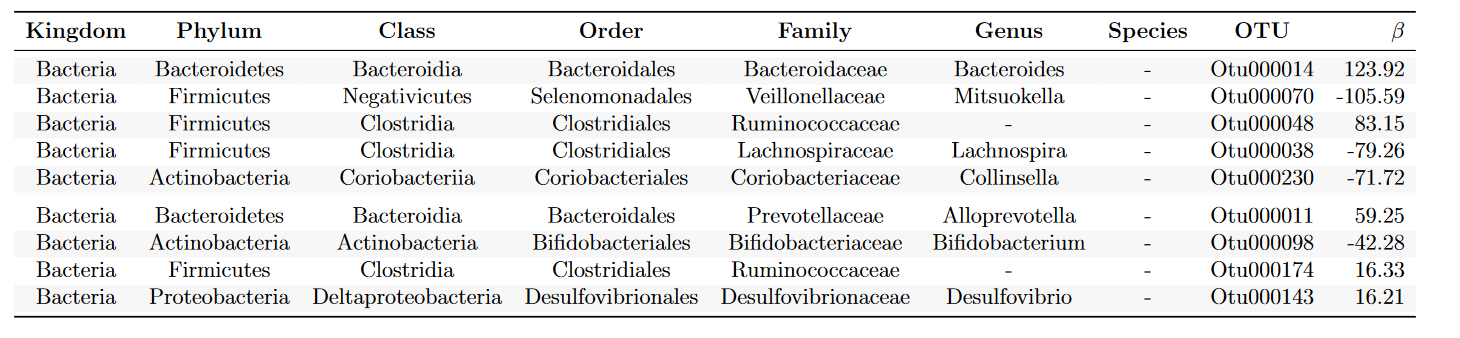

In [14]:
#This doesn't work at the moment
'''
from ete3 import Tree, TreeStyle

def create_tree(taxa):
    # Create a root node
    root = Tree("(Root);")  # Root node

    # Iterate through each row in the DataFrame to build the tree
    for _, row in taxa.iterrows():
        # Construct the path from the taxonomy levels
        path = f"{row['Genus']}"
        
        # Add the node to the tree
        root.add_child(name=path)
    
    return root

# Create the tree
taxa_tree = create_tree(taxa)

# Print the tree
print(taxa_tree)

# Optional: Visualize the tree
ts = TreeStyle()
ts.show_leaf_name = True
taxa_tree.show(tree_style=ts)
'''



   /-Root
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::g__1
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::g__2
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Blautia
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Coprococcus
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Coprococcus
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::g__3
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Coprococcus
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::g__4
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Incertae_Sedis
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Lachnospira
  |
  |--Life::Bacteria::Firmicutes::Clostridia::Clostridiales::Lachnospiraceae::Lachnos